In [2]:
from IPython.core.display import SVG
import numpy as np
import scipy.fft as sfft



# Stripmap SAR System Modeling

## Overview

This notebook will describe the fundamental signal processing and geometric models of Synthetic Aperture Radar (SAR), as well as implement an SAR System Model.

SAR is an imaging technology used by airborne or space-based surveillance platforms.

The key idea of SAR is that a very high resolution can be achieved from a distant platform by emitting a series of radar pulses out of the side of the moving platform.  Along the direction of the radar pulse, which is called the *range direction*, conventional radar methods are used: an emitter produces a radio pulse and a receiver records the returning signal.  Using conventional radar theory, it is possible to infer the position of targets in the range direction due to the roundtrip delay from emitter to receiver, which will be longer for more distant targets.  What distinguishes SAR is that it utilizes the forward movement of the surveillance platform to collect a sequence of pulses in the *azimuth direction.* The sequence can be analyzed to produce a high resolution two-dimensional image.

## System Geometry

In [3]:
SVG(filename='Polyphemus/img/SAR_Platform_Geometry.svg')

FileNotFoundError: [Errno 2] No such file or directory: 'Polyphemus/img/SAR_Platform_Geometry.svg'

The SAR Platform is airborne or in orbit at altitude $z$.  It moves along its flight direction $x$ at a constant velocity $v$.  

At a given moment in flight, a mm wave pulse is transmitted from the side of the aircraft along the range, or $y$, direction. The pulse will illuminate the ground within the range of its beam footprint. Some of the beam energy will reflect back to the aircraft. We will approximate that, relative to the speed of light, the aircraft is moving slowly, so each reflection is received at a point near where it was transmitted.  The returned signal will then be a range-averaged reflectivity of the ground convolved with the beam pattern (distribution of the antenna pattern on the ground), combbined with a dissipation and delay factor as the beam makes its return trip to the receiver.

For a given pulse, then, we receive an "echo' signal in the time domain. Resolution can be quite fine in the range direction, depending on the sampling rate of the time-domain signal, and the wavelength of the pulse.  However, resolution on the $x$ direction, also called **azimuth** or **cross-range**, is not so good.  The ability to resolve points in the $x$ direction will be limited by the beamwidth of the antenna pattern, as it spreads with increasing range.

Lets take two typical examples:

|radar band | antenna length | range | azimuth resolution|
|----|----|----|----|
|X band (10GHz) | 1m | 10km | 300m|
|C-band (5Hz) | 10m | 770km | 4.6km |

The X-band case could be an airborne SAR and the C-band could be a low-earth-orbit vehicle.  Resolution is very poor.  Improving it would require massive antennas or very high frequency radiation.

The SAR alternative is to combine the data from several radar bursts and use post-processing to "refocus" the raw data and produce an image of the scanned surface.
In effect, the moving platform and the post-processing produce a synthesized massive antenna.

The vehicle collects a certain number of echoes as it moves, over a period of time called the *aperture time*, $T_a$.  The size of the aperture $D_{SAR}$ will be given by the product of the aperture time and the veolcity of the platform. 

$$D_{SAR} = v T_a.$$

The seemingly incredible result of post-processing all of the data collected over the aperture is that the resolution in the $x$ direction is now independent of range-to-target, and highly dependent on the data processing capacity of the SAR system.  Also, surprisingly, a smaller antenna (which leads to a wider beam and expands the effective aperture) leads to a higher cross-range resolution as well.

Using SAR, for example, typical resolution from the previous examples is upgraded by 1000x:

|radar band | antenna length | range | azimuth resolution|
|----|----|----|----|
|X band (10GHz) | 1m | 10km | 0.5m |
|C-band (5Hz) | 10m | 770km | 5m |

## Range to Target

We will consider a specific scatterer within the aperture.

Since the platform is moving in the $x$ direction, we will consider the distance to the scatterer to be dependent on $u$, the current position of the platform on the $x$-axis.

The range from the airborne platform at position $(u,0,z)$ to a scatterer $P$ on the ground at $(x_p, y_p, 0)$ is the Euclidean distance:

$$R(u)=\sqrt{(u-x_p)^2 +y_p^2 + h^2}.$$

Let $R_p$ be the range of closest-approach between the platform and the scatterer.

$$R_p^2=x_p^2+y_p^2+h^2.$$

Then 

$$R(u) = R_p\sqrt{1+\frac{(u-xp)^2}{R_p^2}}.$$

*In other words, the range from platform to target will vary quadratically. as data is collected.*

## Phase

The received phase of the echo is shifted by an amount proportional to range.

$$\phi(u)=-\frac{4\pi R(u)}{\lambda}.$$

So, the phase of an echo received from a scatterer will also vary quadratically.

## Instantaneous Spatial Frequency and Bandwidth

We can approximate $R(u)$ with a series expansion:

$$R(u)\approx R_p + \frac{u^2}{2 R_p} - \frac{u x_p}{R_p} + \frac{x_p^2}{2R_p}.$$

If the aperture is much smaller than the range to target, we can neglect the higher order terms and further approximate:

$$R(u)\approx R_p + \frac{u^2}{2 R_p}. $$

The phase received from a scatterer can then be approximated as:

$$\phi(u)\approx - \left(\frac{4 \pi}{\lambda} \right)\left[R_p + \frac{u^2}{R_p}\right].$$

We can no analytically find the instantaneous spatial frequency $k_u$ which we define as $d\phi /du$ by differentiating:

$$d\phi \approx -\frac{4\pi}{\lambda}\left(\frac{2u du}{2R_p}\right). $$
Expressing $u$ as x position relative to the position of closest approach,

$$k_u=\frac{d\phi}{du}\approx -\frac{4 \pi}{\lambda} \frac{u-x_p}{R_p}.$$ 

As a consequence of the limited aperture size $D_{SAR}$, the possible values of $k_u$ will be limited to a sweep across a bandwidth $BW$, where

$$BW = 4\pi / (\lambda R_0) \times D_{SAR}.$$

## x-position

Now that we have $k_u$, it is possible to determine the $x$ position from the phase.

$$(u-x_p) = k_u \frac{\lambda R_p}{4 \pi}$$. 

In [4]:
#Aircraft parameters
v = 100 # aircraft velocity in meters/second
z = 3.e3 #aircraft altitude in meters
y = 0 #aircraft ground range coordinates

## Radar Pulse
The SAR system emits a brief pulse of frequency-modulated modulated radio energy and then receives the radio energy reflected back.  The radio frequency spectrum is conventionally divided into named bands, for example the L-band between 1 and 2 GHz. The carrier signal $f_0$, for example, could be 1.5 GHz.

The wavelength of the carrier is provided by the relation $\lambda=c/f_0$.

The corresponding carrier wavenumber is 
$k_0=2 \pi /\lambda.$

and the angular frequency of the carrier is 
$\omega_0=2 \pi f_0.$

The unmodulated carrier signal is:
$f(t)=\exp(j \omega_0 t). $

The movement of the platform along the $x$-axis effects a linear frequency modulation on the carrier due to the Doppler effect. The bandwidth is given by the previously-derived $BW$ which was the total range of $k_u$ that could be swept across the entire SAR aperture. We simplify by considering the frequency modulation to act like a bandpass filter of width $BW.$ In the time domain, this results in a sinc function.

$$l(t)=sinc(\pi BW t)$$.

The total modulated signal for a single pulse is therefore given by:

$$p(t)=l(t)f(t)=sinc(\pi BW t) \exp(j \omega_0 t)$$.

The pulse is represented digitally by a series of samples collected at a sampling rate sufficient to reconstruct the given bandwidth.

## Reflection of Pulse and Reception

After the pulse is emitted, the wavefront propagates at the speed of light and will encounter scatterers.  Depending on the surface roughness, dielectric characteristics and orientation of the scatterers, a signal will reflect back towards the SAR platform, and the signal over time will be recorded.

Distance from platform to scatterer is:

$$r'=\sqrt{(x-x')^2+(y-y')^2+(z-z')^2}$$

Note that this is half the total distance travelled by a reflected beam received at the platform.

Propagation time to and from will be twice the travel time to the scatterer, which is the scatterer's distance $r'$ divided by the speed of light $c$.

$$t=\frac{2 r'} {c}$$.

The intensity of the radiation dissipated to the square of the distance to the target, so the returning signal is scalled by $1/r'^2$.

The strength of the emitted beam is shaped rather than spherical. Assuming a linear antenna with length L, accounting for propagation in two dimensions and neglecting elevation dependence, the shape of the beam is given by:
$$B(x,y,z,x',y')=sinc^2\left(\frac{\omega_o L (x-x_m)}{2}\right)$$

In the general case, the reflected beam $S(x,t)$ will be proportional to a convolution of the beam shape over the distribution of the scatterign coefficient on the ground. we will consider ideal point targets characterized by a complex backscattering cross section $\sigma.$

Extracting only the baseband (removing the carrier frequency,) the reflected signal is given by:

$$S_B=e^{-j\omega_0t} S(x,t)$$

Summing over $m$ discrete targets, 
$$=\sum_m \sigma_m \frac{l(t-2r'_m/c)}{{r'_m}^2} \times \exp\left({-j\omega_0 2 r'_m/c}\right) B(x,y,z,x'_m,y'_m,z'_m)$$

Substituting for $B,$
$$=\sum_m \sigma_m \frac{l(t-2r'_m/c)}{{r'_m}^2} \times \exp\left({-j\omega_0 2 r'_m/c}\right) sinc^2\left(\frac{\omega_o L (x-x_m)}{2}\right)$$

The scatterer will interact with the beam according to its radar backscattering cross-section, which may be complex and is denoted $\sigma $. 

The final detected signal from a single scatterer will be the product of the radar pulse waveform, the pulse envelope, the 2-d beam shape, and the dissipation factor.

In [7]:
F_shape=np.array([[1, 1, 1, 1, 1, 1, 0, 0],
         [1, 1, 1, 1, 1, 1, 0, 0],
         [1, 1, 0, 0, 0, 0, 0, 0],
         [1, 1, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 0, 0],
         [1, 1, 1, 1, 1, 1, 0, 0],
         [1, 1, 0, 0, 0, 0, 0, 0],
         [1, 1, 0, 0, 0, 0, 0, 0],
         [1, 1, 0, 0, 0, 0, 0, 0],
         [1, 1, 0, 0, 0, 0, 0, 0]])

O_shape=np.array([[1, 1, 1, 1, 1, 1, 0, 0],
         [1, 1, 1, 1, 1, 1, 0, 0],
         [1, 1, 0, 0, 1, 1, 0, 0],
         [1, 1, 0, 0, 1, 1, 0, 0],
         [1, 1, 0, 0, 1, 1, 0, 0],
         [1, 1, 0, 0, 1, 1, 0, 0],
         [1, 1, 0, 0, 1, 1, 0, 0],
         [1, 1, 0, 0, 1, 1, 0, 0],
         [1, 1, 1, 1, 1, 1, 0, 0],
         [1, 1, 1, 1, 1, 1, 0, 0]])


P_shape=np.array([[1, 1, 1, 1, 1, 1, 0, 0],
         [1, 1, 1, 1, 1, 1, 0, 0],
         [1, 1, 0, 0, 1, 1, 0, 0],
         [1, 1, 0, 0, 1, 1, 0, 0],
         [1, 1, 1, 1, 1, 1, 0, 0],
         [1, 1, 1, 1, 1, 1, 0, 0],
         [1, 1, 0, 0, 0, 0, 0, 0],
         [1, 1, 0, 0, 0, 0, 0, 0],
         [1, 1, 0, 0, 0, 0, 0, 0],
         [1, 1, 0, 0, 0, 0, 0, 0]])


S_shape=np.array([[1, 1, 1, 1, 1, 1, 0, 0],
         [1, 1, 1, 1, 1, 1, 0, 0],
         [1, 1, 0, 0, 0, 0, 0, 0],
         [1, 1, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 0, 0],
         [1, 1, 1, 1, 1, 1, 0, 0],
         [0, 0, 0, 0, 1, 1, 0, 0],
         [0, 0, 0, 0, 1, 1, 0, 0],
         [1, 1, 1, 1, 1, 1, 0, 0],
         [1, 1, 1, 1, 1, 1, 0, 0]])

E_shape=np.array([[1, 1, 1, 1, 1, 1, 0, 0],
         [1, 1, 1, 1, 1, 1, 0, 0],
         [1, 1, 0, 0, 0, 0, 0, 0],
         [1, 1, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 0, 0],
         [1, 1, 1, 1, 1, 1, 0, 0],
         [1, 1, 0, 0, 0, 0, 0, 0],
         [1, 1, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 0, 0],
         [1, 1, 1, 1, 1, 1, 0, 0]])

G_shape=np.array([
         [1, 1, 1, 1, 1, 1, 0, 0],
         [1, 1, 1, 1, 1, 1, 0, 0],
         [1, 1, 0, 0, 0, 0, 0, 0],
         [1, 1, 0, 0, 0, 0, 0, 0],
         [1, 1, 0, 1, 1, 1, 0, 0],
         [1, 1, 0, 1, 1, 1, 0, 0],
         [1, 1, 0, 0, 1, 1, 0, 0],
         [1, 1, 0, 0, 1, 1, 0, 0],
         [1, 1, 1, 1, 1, 1, 0, 0],
         [1, 1, 1, 1, 1, 1, 0, 0]])

FOPS_shape=np.block([F_shape, O_shape, P_shape, S_shape])
SEG_shape=np.block([S_shape, E_shape, G_shape])

SAR_shape=SEG_shape

#scatterers=[{'x':490,'y':8000,'z':0,'scattering_coef':1},
#           {'x':500,'y':8100,'z':0,'scattering_coef':1}]#,
#           {'x':530,'y':8050,'z':0,'scattering_coef':1},
#           {'x':510,'y':8000,'z':0,'scattering_coef':10}]

In [8]:
SEG_shape

array([[1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        0, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
        0, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
        0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
        0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
        0, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        0, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        0, 0]])

In [29]:
x_range_start=290
x_range_stop=530
y_range_start=7975
y_range_stop=8075
SAR_y_dim, SAR_x_dim=np.shape(SAR_shape)
SAR_x_range=np.arange(x_range_start,x_range_stop, (x_range_stop-x_range_start)/SAR_x_dim)
SAR_y_range=np.arange(y_range_start,y_range_stop, (y_range_stop-y_range_start)/SAR_y_dim)

SAR_y_coords=np.ndarray.flatten(SAR_shape*np.transpose(SAR_y_range)[:,None])
SAR_x_coords=np.ndarray.flatten(SAR_x_range*SAR_shape)

SAR_coords=tuple(zip(SAR_x_coords, SAR_y_coords))

def get_scatterers_from_coords(coords):
    if coords[0]!=0.0:
        return {'x':coords[0],'y':coords[1],'z':0,'scattering_coef':1}

scatterers=[i for i in list(map(get_scatterers_from_coords,SAR_coords)) if i]

scatterers

[{'x': 290.0, 'y': 7975.0, 'z': 0, 'scattering_coef': 1},
 {'x': 300.0, 'y': 7975.0, 'z': 0, 'scattering_coef': 1},
 {'x': 310.0, 'y': 7975.0, 'z': 0, 'scattering_coef': 1},
 {'x': 320.0, 'y': 7975.0, 'z': 0, 'scattering_coef': 1},
 {'x': 330.0, 'y': 7975.0, 'z': 0, 'scattering_coef': 1},
 {'x': 340.0, 'y': 7975.0, 'z': 0, 'scattering_coef': 1},
 {'x': 370.0, 'y': 7975.0, 'z': 0, 'scattering_coef': 1},
 {'x': 380.0, 'y': 7975.0, 'z': 0, 'scattering_coef': 1},
 {'x': 390.0, 'y': 7975.0, 'z': 0, 'scattering_coef': 1},
 {'x': 400.0, 'y': 7975.0, 'z': 0, 'scattering_coef': 1},
 {'x': 410.0, 'y': 7975.0, 'z': 0, 'scattering_coef': 1},
 {'x': 420.0, 'y': 7975.0, 'z': 0, 'scattering_coef': 1},
 {'x': 450.0, 'y': 7975.0, 'z': 0, 'scattering_coef': 1},
 {'x': 460.0, 'y': 7975.0, 'z': 0, 'scattering_coef': 1},
 {'x': 470.0, 'y': 7975.0, 'z': 0, 'scattering_coef': 1},
 {'x': 480.0, 'y': 7975.0, 'z': 0, 'scattering_coef': 1},
 {'x': 490.0, 'y': 7975.0, 'z': 0, 'scattering_coef': 1},
 {'x': 500.0, 

In [30]:
sim_params={'N_pulses':1024, #number of radar pulses emitted by aircraft
             'xmin':0,       #starting x coordinate position of aircraft
             'N_samples':256,#number of samples i nthe time domain for each pulse
             'rmin':8500,    #minimum range of simulation (for plotting)
             'c':3.e8        #speed of light (m/s)
           }

sim_params['tmin']=2*sim_params['rmin']/sim_params['c']


In [31]:
platform={'v': 100,   #aircraft velocity (m/s)
          'z': 3.e3,  #aircraft altitude (m)
          'y': 0.,    #aircraft ground range coordinate
          'f0':1.5e9, #carrier frequency (Hz)
          'azres':1.0,#theoretical azimuth resolution (m)
          'BW':1.5e8, #pulse bandwidth (Hz)
          'sample_rate':3.e8} # (Hz)
platform['wavelength']=sim_params['c']/platform['f0']
platform['k0']=2*np.pi/platform['wavelength']
platform['omega0']=2*np.pi*platform['f0']
platform['L']=2*platform['azres']

In [32]:
def scatterer_reflection(platform, scatterer, sim_params, beam_factor, pulse_factor, tscat):
    dt=1/platform['sample_rate']
    s=np.zeros((sim_params['N_samples']),dtype=complex)
    for it in range(0,sim_params['N_samples']):
        t=sim_params['tmin']+(it-1)*dt #time of current sample
        pfac = pulse_factor*np.sinc(platform['BW']*(t-tscat)) #sinc pulse envelope. flat spectrum in bandwidth
        s[it]=scatterer['scattering_coef']*pfac*beam_factor #contribution for this scatterer   
    return s

In [33]:
def pulse_return_signal(platform,scatterers, sim_params,x):
    s=np.zeros((sim_params['N_samples']),dtype=complex)
    for scatterer in scatterers:
        r=np.sqrt((x-scatterer['x'])**2. + 
                  (platform['y']-scatterer['y'])**2. +
                  (platform['z']-scatterer['z'])**2.)
        tscat = 2*r/sim_params['c'] #roundtrip propagation time

        pulse_factor=np.exp(np.complex(0.-platform['omega0']*r/sim_params['c']*2j)) #carrier freq
        sinc_arg = platform['k0']*platform['L']/2*(scatterer['x']-x)/r

        beam_factor = np.power(np.sinc(sinc_arg/np.pi),2)/r/r
        s+=scatterer_reflection(platform,scatterer, sim_params, beam_factor, pulse_factor,tscat)
    return s

In [34]:
def aircraft_SAR_acquisition(platform, scatterers,sim_params):
    s=np.zeros((sim_params['N_samples']),dtype=complex)
    for ix in range(0,sim_params['N_pulses']):
        x=sim_params['xmin'] +(ix-1)*platform['azres'] #radar x coordinate
        s=np.vstack([s,pulse_return_signal(platform,scatterers,sim_params,x)])
    return s[1:,:]

In [35]:
s=aircraft_SAR_acquisition(platform,scatterers,sim_params)

In [36]:
%matplotlib inline

In [37]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from colorsys import hls_to_rgb
def colorize(z):
    r = np.abs(z)
    arg = np.angle(z) 

    h = (arg + np.pi)  / (2 * np.pi) + 0.5
    l = 1.0 - 1.0/(1.0 + r**0.3)
    s = 0.8

    c = np.vectorize(hls_to_rgb) (h,l,s) # --> tuple
    c = np.array(c)  # -->  array of (3,n,m) shape, but need (n,m,3)
    c = c.swapaxes(0,2) 
    return c

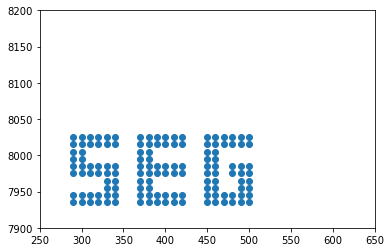

In [38]:

fig, ax = plt.subplots()
ax.set_xlim(left=250,right=650)
ax.set_ylim(bottom=7900,top=8200)
plt.scatter( SAR_x_coords, -SAR_y_coords+16000) #/np.power(np.max(np.real(s)),2))# img)


plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


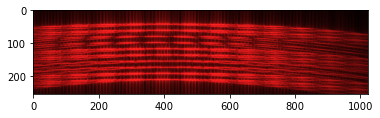

In [39]:
smag=np.abs(s)**2
img=colorize(smag/np.max(np.abs(smag)))
plt.imshow( img*2) #/np.power(np.max(np.real(s)),2))# img)
plt.show()

## SAR Processing

We have simulated the acquisition of stripmap SAR data, a series of time-domain "echoes" from a radar chirp pulse collected from a moving airborne platform. We now want to reconstruct the *image* of the scatterer placement in the *ground range.* From this we will identify the placement of the targets on the ground-range coordinate system.

### Range Migration Algorithm

 
The range migration algorithm transforms the collected data, which is given by $S_B(x,t)$ and in terms of $x$ and $t$, into an image that shows the positions of the targets in range coordinates, $C(x_0,y_0)$. It does this by first transforming the data from (x,t) into the frequency domain $(k_u,\omega)$ using an FFT. 

$$\bar S(k_u,\omega)=\int S_B(x,t) e^{-jk_u x - j \omega t} dx d.$$


The term $k_u$ was defiend previously as the instantaneous spatial frequency along the x-direction. From $k_x$ and $\omega$ it is possible to reconstruct $k_y$ using the relationship:

$$k_y=\sqrt{\left(\frac{2\omega}{c}\right)^2-{k_x}^2}.$$

We interpolate from the $\omega-space$ onto the $y$-space for each pair $(k_x,\omega)$ to calculate

$$\bar S(k_u,k_y)$$

We then change variables from wave
=\int S_B(x,t) e^{-jk_u x - j \omega t} dx d.$$

In [40]:
omega0= 2* np.pi * platform['f0']    # angular frequency of carrier signal
k0 = 2*omega0/sim_params['c']        # wavenumber corresponding to omega0
dt=1/platform['sample_rate']         # time domain grid spacing in (s) is 1/sampling rate Hz
dr=dt*sim_params['c']/2              # range domain grid spacing (m) is scaled from time domain grid by c/2 (m/s)
nx,nr = np.shape( s )         # copy grid dimensions from acquired data
nt = nr                              # number of samples in time domain is same as range
dx=platform['azres']
#pad data to next power of 2 in azimuth and range dimensions to prepr for FFT

px = int(np.ceil(np.log2(nx)))
nkx= np.power(2,px)
pr = int(np.ceil(np.log2(nr)))
nkr = np.power(2, pr+1)
 
xpad=(nkx-nx)
rpad=(nkr-nr)
#    print(nkx,nx,nkr,nr,xpad,np.ceil(xpad),np.floor(xpad),rpad)

data_padded = np.pad(s,((0,xpad),(0,rpad)))

#### FFT

The first step in the algorithm is to convert the acquired data into the frequency domain with a 2D FFT. To prepare for the FFT, we place the acquired data into a matrix with dimensions set at the smallest powers-of-two that can contain all of the original data, padding with zeros if necessary.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


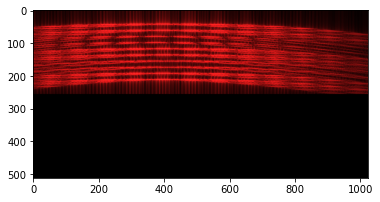

In [41]:
nx,nr = np.shape( s )         # copy grid dimensions from acquired data
nt = nr                              # number of samples in time domain is same as range

#pad data to next power of 2 in azimuth and range dimensions to prepr for FFT

px = int(np.ceil(np.log2(nx)))
nkx= np.power(2,px)
pr = int(np.ceil(np.log2(nr)))
nkr = np.power(2, pr+1)  #doubled resolution for nyquist sampling criteria (no aliasing)
 
xpad=(nkx-nx)
rpad=(nkr-nr)
#    print(nkx,nx,nkr,nr,xpad,np.ceil(xpad),np.floor(xpad),rpad)

data_padded = np.pad(s,((0,xpad),(0,rpad)))
smag=np.abs(data_padded)**2
img=colorize(smag/np.max(np.abs(smag)))
plt.imshow( img*2) #/np.power(np.max(np.real(s)),2))# img)
plt.show()

To prepare for the change of variables into frequency domain, we rescale into Omega-K space. 

In [42]:


dkx = 2*np.pi/(nkx*dx)                            #azimuth frequency resolution
dkr = 2*np.pi/(nkr*dr)  #sampling in freq domain must be at 2x resolution for nyquist
kxmin = -(nkx/2-1)*dkx     #min value of azimuth freq
krmin = -(nkr/2-1)*dkr+k0  #min value of range frequency

domega = 2*np.pi/(nkr)*platform['sample_rate']     #angular frequency resolution corresponding to range
omegamin=-(nkr/2-1)*domega+omega0

#create vectors of azimuth, range and angular freq vectors
kx = kxmin +np.arange(0,nkx)*dkx
kr = krmin +np.arange(0,nkr)*dkr
omega = omegamin + np.arange(0,nkr)*domega

Now we perform the 2D FFT on the padded acquired data and shift it for convenience.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


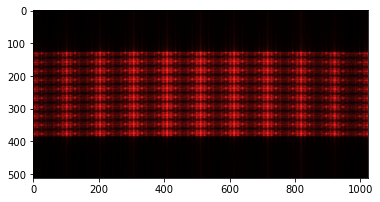

In [43]:
data_omega_k = sfft.fftshift(sfft.fft2(data_padded))

smag=np.abs(data_omega_k)**2
img=colorize(smag/np.max(np.abs(smag)))
plt.imshow( img*2) #/np.power(np.max(np.real(s)),2))# img)
plt.show()

In [44]:
image= np.zeros((nkx,nkr),dtype=np.complex)
weight = np.kaiser(nkx,4) #window to reduce sidelobes
for ikr in range(nkr):

    for ikx in range(nkx):
        k=np.sqrt(kx[ikx]**2+kr[ikr]**2)

        om=sim_params['c']*k/2.
        iom = np.int(np.floor((om-omegamin)/domega))
        if (iom>=nkr-1):
            image[ikx,ikr]=0
        else:
            del_om = om-((iom)*domega+omegamin)
            jacobian = kr[ikr]/k
            image[ikx,ikr] = (data_omega_k[ikx,iom]) + \
                    (data_omega_k[ikx,iom+1] - \
                         data_omega_k[ikx,iom]) * del_om/domega
            image[ikx,ikr]=image[ikx,ikr]*jacobian *\
                           np.exp(0-(k-kr[ikr])*sim_params['rmin']*1.j) * \
                                weight[ikx]



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


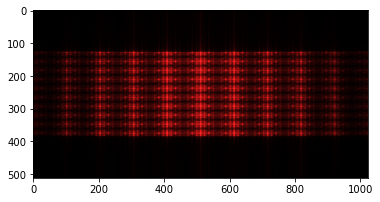

In [45]:
img=np.abs(image)**2
img=colorize(img/np.max(img))
plt.imshow( img*2) #/np.power(np.max(np.real(s)),2))# img)
plt.show()

In [46]:
image=sfft.ifft2(sfft.ifftshift(image))[0:nx,0:nr]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


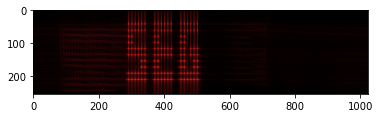

In [47]:
img=np.abs(image)**2
img=colorize(img/np.max(img))
plt.imshow( img*2) #/np.power(np.max(np.real(s)),2))# img)
plt.show()

In [163]:
import numpy as np 
import scipy.fft as sfft

def RangeMigrationAlgorithm( raw_data, dx, dr, r0, f0):
    """
    adapted from 'Systems engineering of phased arrays' yb sturdivant et. al
    
    INPUT
    raw_data is a complex array, dimensions nx by nr, 
        where x is azimuth and r is range coordinates.
    dx, dr = x and r grid sizes (pitch)
    r0 = starting range of data
    f0 = signal center frequency

    OUTPUT

    image is an nx by nr complex image

    """
    pi=np.pi
    c = 3.e8              # speed of light in m/s
    omega0= 2* pi * f0    # angular frequency of signal
    k0 = 2*omega0/c       # wavenumber corresponding to omega0
    dt = 2*dr /c          # range grid size div by c is time in range domain
    nx,nr = np.shape( raw_data ) 
    nt = nr               # number of samples in time domain is same as range
    
    #pad data to next power of 2 in azimuth and range dimensions
 
    px = int(np.ceil(np.log2(nx)))
    nkx= np.power(2,px)
    pr = int(np.ceil(np.log2(nr)))
    nkr = np.power(2, pr+1)
 
#    print(px,nkx,pr,nkr)
    #define fourier domain grid parameters
    dkx = 2*pi/(nkx*dx)     #azimuth frequency resolution
    dkr = 2*pi/(nkr*dr)     #range frequency resolution
    kxmin = -(nkx/2-1)*dkx     #min value of azimuth freq
    krmin = -(nkr/2-1)*dkr+k0  #min value of range frequency
    domega = 2*pi/(nkr*dt)     #angular frequency resolution corresponding to range
    omegamin=-(nkr/2-1)*domega+omega0
  
    #create vectors of azimuth, range and angular freq vectors
    kx = kxmin +np.arange(0,nkx)*dkx
    kr = krmin +np.arange(0,nkr)*dkr
    omega = omegamin + np.arange(0,nkr)*domega
    #pad data to next power of 2 and fft

    xpad=(nkx-nx)
    rpad=(nkr-nr)
    data_padded = np.pad(raw_data,((0,xpad),(0,rpad)))
    data_omega_k = sfft.fftshift(sfft.fft2(data_padded))


    weight = np.kaiser(nkx,4) #window to reduce sidelobes
    image= np.zeros((nkx,nkr),dtype=np.complex)

    for ikr in range(nkr):

        for ikx in range(nkx):
            k=np.sqrt(kx[ikx]**2+kr[ikr]**2)

            om=c*k/2.
            iom = np.int(np.floor((om-omegamin)/domega))
            if (iom>=nkr-1):
                image[ikx,ikr]=0
            else:
                del_om = om-((iom)*domega+omegamin)
                jacobian = kr[ikr]/k

                image[ikx,ikr] = (data_omega_k[ikx,iom]) + \
                        (data_omega_k[ikx,iom+1] - \
                             data_omega_k[ikx,iom]) * del_om/domega
                image[ikx,ikr]=image[ikx,ikr]*jacobian *\
                               np.exp(0-(k-kr[ikr])*r0*1.j) * \
                                    weight[ikx]
    image=sfft.ifft2(sfft.ifftshift(image))

    return image[0:nx,0:nr]




In [164]:
dt=1/platform['sample_rate']
dr=dt*sim_params['c']/2
image=RangeMigrationAlgorithm(s,platform['azres'],dr,sim_params['rmin'],platform['f0'])

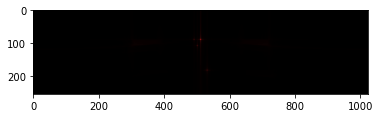

In [165]:
image=np.abs(image)**2
img=colorize(image/np.max(image))
plt.imshow(img)
plt.show()

If the duration of the emitted pulses $\delta_\tau$ are short we can approximate that the platform is stable during the pulse and its return. For each pulse, the platform moves $\delta_x = v \delta_\tau$.


It emits a pulse directed along the y-axis at regular intervals. Each pulse illuminates an area on the ground, which contains one or more targets which scatter the radiation.

If the duration of the emitted pulses $\delta_\tau$ are short we can approximate that the platform is stable during the pulse and its return. For each pulse, the platform moves $\delta_x=v \delta_\tau$.

| Quantity | Example Value |
|----|----|
| Frequency (L-Band) | f=1.5 GHz |
| Bandwidth | B = 150 MHz |
| Slant range resolution | deltar_R = 1m |
| Pulse repetition frequency (PRF) | 100 Hz |
| Antenna length | L=2m |
| Azimuthal resolution | delta_AZ = 1m |
| Platform velocity | v=100 m/s |
| Platform altitude | z=3 km |
| Sample rate | 300 MHz |

In [125]:
import numpy as np 
import scipy.fft as sfft

def RangeMigrationAlgorithm( raw_data, dx, dr, r0, f0):
    """
    adapted from 'Systems engineering of phased arrays' yb sturdivant et. al
    
    INPUT
    raw_data is a complex array, dimensions nx by nr, 
        where x is azimuth and r is range coordinates.
    dx, dr = x and r grid sizes (pitch)
    r0 = starting range of data
    f0 = signal center frequency

    OUTPUT

    image is an nx by nr complex image

    """
    pi=np.pi
    c = 3.e8              # speed of light in m/s
    omega0= 2* pi * f0    # angular frequency of signal
    k0 = 2*omega0/c       # wavenumber corresponding to omega0
    dt = 2*dr /c          # range grid size div by c is time in range domain
    nx,nr = np.shape( raw_data ) 
    nt = nr               # number of samples in time domain is same as range
    
    #extend indices to pad data to next power of 2 in azimuth and range dimensions
 
    px = int(np.ceil(np.log2(nx)))
    nkx= np.power(2,px)
    pr = int(np.ceil(np.log2(nr)))
    nkr = np.power(2, pr+1)
 
    #define fourier domain grid parameters
    dkx = 2*pi/(nkx*dx)     #azimuth frequency resolution
    dkr = 2*pi/(nkr*dr)     #range frequency resolution
    kxmin = -(nkx/2-1)*dkx     #min value of azimuth freq
    krmin = -(nkr/2-1)*dkr+k0  #min value of range frequency
    domega = 2*pi/(nkr*dt)     #angular frequency resolution corresponding to range
    omegamin=-(nkr/2-1)*domega+omega0
  
    #create vectors of azimuth, range and angular freq vectors
    kx = kxmin +np.arange(0,nkx)*dkx
    kr = krmin +np.arange(0,nkr)*dkr
    omega = omegamin + np.arange(0,nkr)*domega

    #pad data to next power of 2 and fft

    xpad=(nkx-nx)
    rpad=(nkr-nr)


    data_padded = np.pad(raw_data,((0,xpad),(0,rpad)))
    data_omega_k = sfft.fftshift(sfft.fft2(data_padded))

    weight = np.kaiser(nkx,4) #window to reduce sidelobes
    image= np.zeros((nkx,nkr),dtype=np.complex)

    for ikr in range(nkr):

        for ikx in range(nkx):
            k=np.sqrt(kx[ikx]**2+kr[ikr]**2)

            om=c*k/2.
            iom = np.int(np.floor((om-omegamin)/domega))
            if (iom>=nkr-1):
                image[ikx,ikr]=0
            else:
                del_om = om-((iom)*domega+omegamin)
                jacobian = kr[ikr]/k
                image[ikx,ikr] = (data_omega_k[ikx,iom]) + \
                        (data_omega_k[ikx,iom+1] - \
                             data_omega_k[ikx,iom]) * del_om/domega
                image[ikx,ikr]=image[ikx,ikr]*jacobian *\
                               np.exp(0-(k-kr[ikr])*r0*1.j) * \
                                    weight[ikx]

    image=sfft.ifft2(sfft.ifftshift(image))
    print(image)
    return image[0:nx,0:nr]



In [126]:
dat = np.ones((3,3),dtype=float)

In [127]:
dat[1,1]=2
dat

array([[1., 1., 1.],
       [1., 2., 1.],
       [1., 1., 1.]])

In [128]:
np.sqrt(1.57079633*1.57079633+2.35619445*2.35619445)

2.8317933181205635

In [129]:
iom=RangeMigrationAlgorithm(dat,1,1,1,1)

[[-3.82189093e-02-2.91197063e-02j  1.17690887e-02+2.17633433e-01j
   1.80669254e-02+1.54455912e-01j  8.76609142e-02+9.54256933e-09j
  -3.04846437e-02-1.05904321e-01j  1.17690942e-02+4.23116189e-02j
  -1.53090933e-01-8.57523278e-02j -8.76609024e-02-7.91212292e-09j]
 [ 1.81110870e-01-2.69511646e-01j  4.10921143e-01-1.80384449e-01j
   2.69799156e-01-6.53837478e-02j  2.47033195e-08-8.76609206e-02j
  -5.85875263e-02+1.45827902e-01j  2.35599359e-01-1.80384414e-01j
  -3.93482866e-01-5.71396703e-02j -1.02386829e-08+8.76609042e-02j]
 [-5.94890191e-02-5.03734568e-01j  1.17691107e-02-5.73895230e-01j
   3.93370343e-02-3.20158968e-01j -8.76609067e-02-3.15923556e-08j
   1.96187689e-01+1.63308323e-01j  1.17691766e-02-3.98573407e-01j
  -3.79763351e-01+1.83460213e-01j  8.76609012e-02+1.13132245e-08j]
 [-2.93503992e-01-2.48241537e-01j -3.80607520e-01-1.80384471e-01j
  -2.04815724e-01-8.66538566e-02j -1.64316055e-08+8.76609003e-02j
   2.10625118e-01-8.08444302e-02j -2.05285667e-01-1.80384497e-01j
  -1.24

In [130]:
iom

array([[-0.03821891-0.02911971j,  0.01176909+0.21763343j,
         0.01806693+0.15445591j],
       [ 0.18111087-0.26951165j,  0.41092114-0.18038445j,
         0.26979916-0.06538375j],
       [-0.05948902-0.50373457j,  0.01176911-0.57389523j,
         0.03933703-0.32015897j]])

In [131]:
#Aircraft parameters
v = 100 # aircraft velocity in meters/second
z = 3.e3 #aircraft altitude in meters
y = 0 #aircraft ground range coordinates

In [132]:
#Radar system parameters
f0=1.5e9 #L band, 1.5GHz
c=3.e8  #speed of light in m/s
wavelen0 = c/f0 # wavelength in meters
k0 = 2*np.pi/wavelen0 # wavenumber
omega0 = 2*np.pi*f0 #angular frequency of carrier signal
azres = 1.0 # azimuthal resolution in meters
ant_len = 2*azres #antenna length as defined by azimuth resolution
Dtau = azres/v #pulse interval
BW = 1.5e8 #bandwidth in Hz
pw=1/BW    #pulse width in seconds
sample_rate = 3.e8 #0.3 GHz sample rate


In [133]:
#Target parameters
Nscat = 3                #number of scatterers
xscat = [490, 500, 510]  #x coordinates of targets
yscat=[8000, 8010, 8000] #y cooridnates of targets
zscat = [0,0,0]          #z coordinates of targets
sscat=[1,1,1]            #scattering strength (may be complex)

In [134]:
#Simulation data parameters
Nx = 1024 #number of pulese
xmin = 0 #along-track position of aircraft at time = 0
dx=v*Dtau #along-track distance between pulses
Nt = 256 #numbebr of time samples per pulse
rmin=8500 #minimum simulation range
tmin = 2*rmin/c #starting time of data corresponding to the slant range
dt=1/sample_rate

In [135]:
s=np.zeros((Nx,Nt),dtype=complex)
#loop over aircraft position
for ix in range(0,Nx):
    x=xmin +(ix-1)*dx #radar x coordinate
    for iscat in range(0,Nscat):
        r=np.sqrt((x-xscat[iscat])**2. + 
                  (y-yscat[iscat])**2. +
                  (z-zscat[iscat])**2.)
        tscat = 2*r/c #roundtrip propagation time
#        print(tscat)#,xscat[iscat],x,np.power((x-xscat[iscat]),2))
        pulsefactor=np.exp(np.complex(0.-omega0*r/c*2j)) #carrier freq
#        tester=np.exp(-2*omega0*r/c*1.j)
        sinc_arg = k0*ant_len/2*(xscat[iscat]-x)/r

        beamfactor = np.power(np.sinc(sinc_arg/np.pi),2)/r/r
        for it in range(0,Nt):
            t=tmin+(it-1)*dt #time of current sample
            pfac = pulsefactor*np.sinc(BW*(t-tscat)) #sinc pulse envelope. flat spectrum in bandwidth
            s[ix,it]+=sscat[iscat]*pfac*beamfactor #contribution for this scatterer            




In [136]:
dr=dt*c/2
image=RangeMigrationAlgorithm(s,dx,dr,rmin,f0)

[[-1.76768386e-13-5.01574933e-13j -1.69146727e-13+1.57527041e-14j
   1.65787554e-13+5.17584390e-13j ...  2.69045295e-16+6.45358604e-14j
  -5.66426885e-14-8.20872397e-14j -1.03331522e-14-6.98873501e-14j]
 [-3.12240084e-13-6.60796348e-13j -1.88948207e-13-1.21730256e-13j
   3.17441711e-13+6.68687925e-13j ... -7.48287470e-16-6.89035713e-14j
   6.30867229e-14+8.39940845e-14j -1.64036961e-15+7.10765897e-14j]
 [-1.70883249e-13-5.04378879e-13j -1.67347302e-13+1.64605835e-14j
   1.56561365e-13+5.22515258e-13j ... -3.41535102e-16+6.65123086e-14j
  -6.32191184e-14-7.98323506e-14j -1.00379554e-14-7.27297811e-14j]
 ...
 [-2.88195516e-13-6.75053641e-13j -1.85229294e-13-1.32112745e-13j
   2.94145713e-13+6.80266314e-13j ... -8.08327248e-16-6.86990534e-14j
   5.97081992e-14+8.35168058e-14j -5.20579755e-15+6.88966590e-14j]
 [-1.69487391e-13-5.04076422e-13j -1.67493040e-13+1.00549490e-14j
   1.55763210e-13+5.22701327e-13j ...  1.17232022e-15+6.42035341e-14j
  -5.62652004e-14-8.15644346e-14j -6.79399499e-

In [137]:
%matplotlib inline


In [138]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [139]:
from colorsys import hls_to_rgb

In [140]:
def colorize(z):
    r = np.abs(z)
    arg = np.angle(z) 

    h = (arg + np.pi)  / (2 * np.pi) + 0.5
    l = 1.0 - 1.0/(1.0 + r**0.3)
    s = 0.8

    c = np.vectorize(hls_to_rgb) (h,l,s) # --> tuple
    c = np.array(c)  # -->  array of (3,n,m) shape, but need (n,m,3)
    c = c.swapaxes(0,2) 
    return c

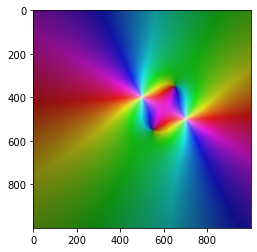

In [141]:
N=1000
x,y = np.ogrid[-5:5:N*1j, -5:5:N*1j]
z = x + 1j*y

w = 1/(z+1j)**2 + 1/(z-2)**2
img = colorize(w)
plt.imshow(img)
plt.show()

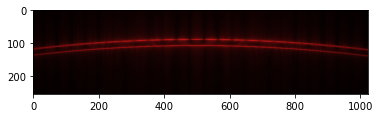

In [142]:
smag=np.abs(s)**2
img=colorize(smag/np.max(np.abs(smag)))
plt.imshow( img) #/np.power(np.max(np.real(s)),2))# img)
plt.show()

In [143]:
image

array([[-1.76768386e-13-5.01574933e-13j, -1.69146727e-13+1.57527041e-14j,
         1.65787554e-13+5.17584390e-13j, ...,
         2.60449658e-13+5.43454103e-14j, -3.45707325e-13-5.36267463e-13j,
        -2.66960907e-13-4.12531197e-14j],
       [-3.12240084e-13-6.60796348e-13j, -1.88948207e-13-1.21730256e-13j,
         3.17441711e-13+6.68687925e-13j, ...,
         2.54141633e-13+4.50757228e-14j, -3.44046414e-13-5.44122264e-13j,
        -2.61085256e-13-4.02139203e-14j],
       [-1.70883249e-13-5.04378879e-13j, -1.67347302e-13+1.64605835e-14j,
         1.56561365e-13+5.22515258e-13j, ...,
         2.53056392e-13+5.34272952e-14j, -3.37271607e-13-5.42994219e-13j,
        -2.58282957e-13-4.69247724e-14j],
       ...,
       [-2.88195516e-13-6.75053641e-13j, -1.85229294e-13-1.32112745e-13j,
         2.94145713e-13+6.80266314e-13j, ...,
         2.55332854e-13+5.89084800e-14j, -3.23725372e-13-5.53691988e-13j,
        -2.62722933e-13-5.27172305e-14j],
       [-1.69487391e-13-5.04076422e-13j, -1.

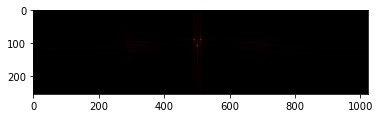

In [144]:
image=np.abs(image)**2
img=colorize(image/np.max(image))
plt.imshow(img)
plt.show()

In [45]:
im

NameError: name 'im' is not defined